In [99]:
import time
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from plots import *

## KNN Class

In [100]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    @staticmethod
    def distance(x, y):
        return np.linalg.norm(x - y)
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
        
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
    
    def _predict(self, x):
        distances = [self.distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Calculate inverse distances
        inv_distances = [1 / d if d != 0 else float('inf') for d in distances]
        
        # Weighted voting
        vote_counts = Counter()
        for i, label in zip(k_indices, k_nearest_labels):
            vote_counts[label] += inv_distances[i]  # Weighted voting
            
        # Get the most common label
        most_common = vote_counts.most_common(1)
        return most_common[0][0]
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def get_params(self, deep=True):
        return {'k': self.k}
    
    def set_params(self, **params):
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self


## PCA Function

In [101]:
def pca_reduction(matrix, n_components=2):
    covariance_matrix = np.cov(matrix.transpose()) # Transpose the features into row vectors, to compute the covariance between the random variables
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix) # Compute the eigenvalues and vectors for the covariance matrix 
    indices = np.argsort(eigenvalues)[::-1][:n_components] # Sort in descending order
    eigenvalues, eigenvectors = eigenvalues[indices], eigenvectors[:, indices] # Numpy returns the eigenvectors as column vectors, therefore we sort along the columns
    result = matrix @ eigenvectors
    return dict(eigenvalues=eigenvalues, eigenvectors=eigenvectors, matrix=np.array(result))

## Mectris Function

In [102]:
def metrics(idx, labels, predictions):
    return np.array([
        accuracy_score(labels, predictions),
        f1_score(labels, predictions, pos_label=idx, zero_division=1),
        recall_score(labels, predictions, pos_label=idx, zero_division=1),
        precision_score(labels, predictions, pos_label=idx, zero_division=1)
    ])

## Fit and Predict Function

In [103]:
def fit_predict(k, x_train, y_train, x_test, y_test):
    clf = KNN(k=k)
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    metrics_class_0 = metrics(0, labels=y_test, predictions=predictions)
    metrics_class_1 = metrics(1, labels=y_test, predictions=predictions)
    return dict(accuracy=metrics_class_1[0], predictions=predictions, clf=clf, metrics=dict(class0=metrics_class_0, class1=metrics_class_1))

## Load Dataset

In [104]:
dataset = pd.read_csv('./dataset/Social_Network_Ads.csv')
dataset.drop('User ID', axis=1, inplace=True)

## Encode numerical and categorical features

In [105]:
ordinal_encoder = OrdinalEncoder()
scaler_salary = MinMaxScaler()
scaler_age = MinMaxScaler()
dataset.Gender = ordinal_encoder.fit_transform(dataset.Gender.array.reshape(-1, 1))
dataset.EstimatedSalary = scaler_salary.fit_transform(dataset.EstimatedSalary.array.reshape(-1, 1))
dataset.Age = scaler_age.fit_transform(dataset.Age.array.reshape(-1, 1))

In [106]:
data = np.array(dataset)

# Split data into features and Labels

In [107]:
X, y = data[:, :-1], data[:, -1]

## Compare my pca against scikits pca

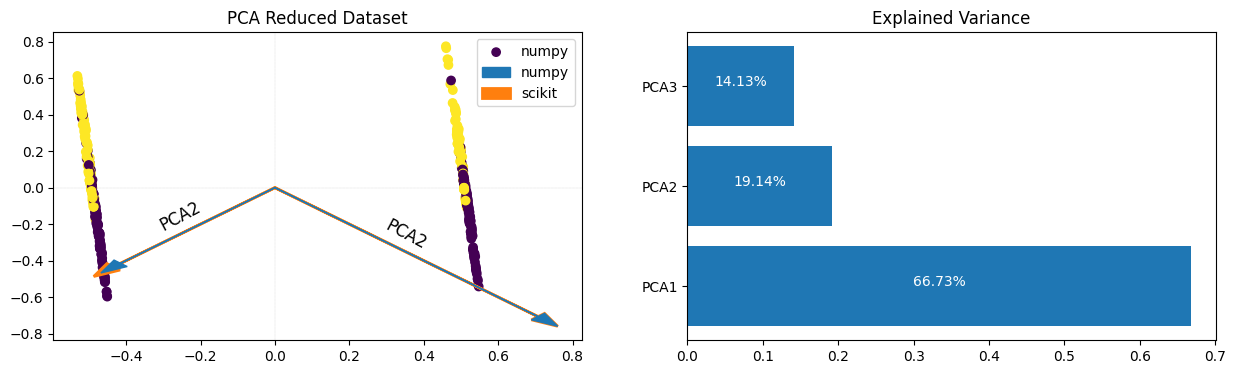

In [108]:
plot_pca(X, pca_reduction, y)

In [109]:
from sklearn.model_selection import cross_val_score

In [110]:
results = []
reduced = pca_reduction(X, 3)['matrix']
for k in tqdm(range(1, 200)):
    scores = cross_val_score(estimator=KNN(k=k), X=X, y=y, cv=5)
    pc1 = cross_val_score(estimator=KNN(k=k), X=reduced[:, :1], y=y, cv=5)
    pc2 = cross_val_score(estimator=KNN(k=k), X=reduced[:, :2], y=y, cv=5)
    pc3 = cross_val_score(estimator=KNN(k=k), X=reduced[:, :3], y=y, cv=5)
    results.append(dict(
        k=k, mean=scores.mean(), 
        pc1_mean=pc1.mean(), 
        pc2_mean=pc2.mean(), 
        pc3_mean=pc3.mean(), 
        std=scores.std(), 
        pc1_std=pc1.std(), 
        pc2_std=pc2.std(), 
        pc3_std=pc3.std(), 
    ))

  0%|          | 0/199 [00:00<?, ?it/s]

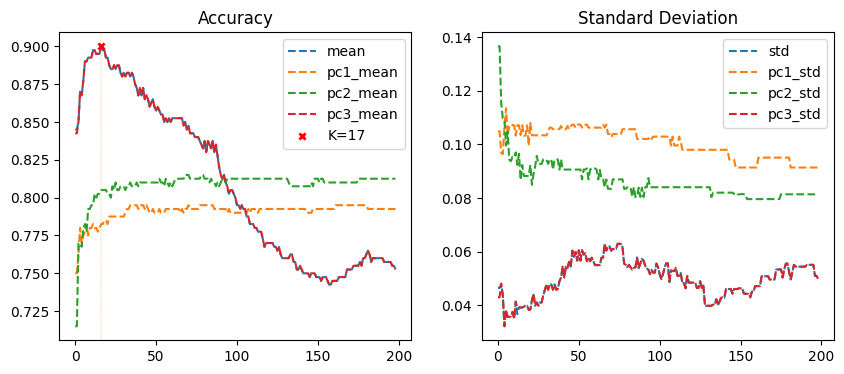

In [111]:
cv = pd.DataFrame(results)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
cv[['mean', 'pc1_mean', 'pc2_mean', 'pc3_mean']].plot(linestyle='--', ax=ax1, title='Accuracy')
cv[['std', 'pc1_std', 'pc2_std', 'pc3_std']].plot(linestyle='--', ax=ax2, title='Standard Deviation')
ax1.axvline(np.argmax(cv['mean']), linestyle='--', color='tab:orange', zorder=-1, linewidth=0.2)
idx = np.argmax(cv['mean'])
ax1.scatter(idx, cv['mean'][idx], zorder=10, s=20, marker='x', color='red', label=f'K={x + 1}', linewidth=2)
ax1.legend()

In [112]:
best_k = cv['k'][idx]

In [113]:
%%timeit
scores = cross_val_score(estimator=KNN(k=best_k), X=X, y=y, cv=5)

1.09 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
%%timeit
pc1 = cross_val_score(estimator=KNN(k=best_k), X=reduced[:, :1], y=y, cv=5)

941 ms ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [115]:
%%timeit
pc2 = cross_val_score(estimator=KNN(k=best_k), X=reduced[:, :2], y=y, cv=5)

994 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [116]:
%%timeit
pc3 = cross_val_score(estimator=KNN(k=best_k), X=reduced[:, :3], y=y, cv=5)

1.06 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
training_time = [
    dict(pca='original', time=f'246 ms', std='66.6 ms', k=best_k, score=round(cross_val_score(estimator=KNN(k=best_k), X=X, y=y, cv=5).mean(), 2)),
    dict(pca='pc1', time=f'206 ms', std='4.12 ms', k=best_k, score=round(cross_val_score(estimator=KNN(k=best_k), X=reduced[:, :1], y=y, cv=5).mean(), 2)),
    dict(pca='pc2', time=f'206 ms', std='4.35 ms', k=best_k, score=round(cross_val_score(estimator=KNN(k=best_k), X=reduced[:, :2], y=y, cv=5).mean(), 2)),
    dict(pca='pc3', time=f'241 ms', std='49 ms', k=best_k, score=round(cross_val_score(estimator=KNN(k=best_k), X=reduced[:, :3], y=y, cv=5).mean(), 2)),
]
training_time

[{'pca': 'original',
  'time': '246 ms',
  'std': '66.6 ms',
  'k': 17,
  'score': 0.9},
 {'pca': 'pc1', 'time': '206 ms', 'std': '4.12 ms', 'k': 17, 'score': 0.78},
 {'pca': 'pc2', 'time': '206 ms', 'std': '4.35 ms', 'k': 17, 'score': 0.8},
 {'pca': 'pc3', 'time': '241 ms', 'std': '49 ms', 'k': 17, 'score': 0.9}]